<a href="https://colab.research.google.com/github/pedrohortencio/data-analysis-projects/blob/main/NYC%20Parking%20Violations/NYC_Parking_Violations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Full violations data from NYC Open Data](https://data.cityofnewyork.us/City-Government/Parking-Violations-Issued-Fiscal-Year-2021/pvqr-7yc4)

[Raw .csv data (subset of 50,000 rows)](https://raw.githubusercontent.com/pedrohortencio/data-analysis-projects/main/NYC%20Parking%20Violations/violations.csv)


[Original project](https://towardsdatascience.com/learn-python-data-analytics-by-example-ny-parking-violations-e1ce1847fa2)

### Importing the data file

In [408]:
import pandas as pd
import numpy as np

In [409]:
url = 'https://raw.githubusercontent.com/pedrohortencio/data-analysis-projects/main/NYC%20Parking%20Violations/violations.csv'

# Importing .csv from the URL
df = pd.read_csv(url)
df.head()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
0,4714702166,KGK6659,NY,PAS,11/12/2020,36,4DSD,BMW,V,0,0,0,0,NaN,0,0,0,NaN,NaN,0637P,NaN,BK,NaN,NaN,WB ATLANTIC AVE @ SH,EPHERD AVE,0,1180,B,T,NaN,NaN,NaN,GY,NaN,2007,NaN,0,NaN,PHTO SCHOOL ZN SPEED VIOLATION,NaN,NaN,NaN
1,8793684599,L5232HY,TN,PAS,09/14/2020,21,TRAC,INTER,T,60790,31140,31190,20200888,101.0,101,101,367421,T402,N,0853A,NaN,Q,O,4212,Rockaway Beach Blvd,NaN,0,408,D1,NaN,Y,0830A,1000A,WHITE,NaN,0,NaN,0,W,NaN,NaN,NaN,NaN
2,8864757053,BPMN76,FL,PAS,11/25/2020,20,SUBN,NISSA,T,36030,31190,10610,20200688,28.0,28,28,367911,T103,FF,0853A,NaN,NY,F,130,W 113th St,NaN,0,408,d,NaN,YYYYYYY,NaN,NaN,BLACK,NaN,0,NaN,0,49,20A-No Parking (Non-COM),NaN,NaN,NaN
3,8778326047,57387MJ,NY,COM,08/20/2020,38,VAN,NaN,T,34430,10410,13610,20211231,13.0,13,13,368567,T506,X,0444P,NaN,NY,F,4,W 33rd St,NaN,0,408,I3,NaN,YYYYY,0700A,0700P,WH,NaN,2016,NaN,0,01,NaN,NaN,NaN,NaN
4,4706640702,M81KFJ,NJ,PAS,09/09/2020,36,UT,TOYOT,V,0,0,0,0,NaN,0,0,0,NaN,NaN,0723A,NaN,BK,NaN,NaN,WB FOSTER AVE @ E 18,TH ST,0,1180,B,T,NaN,NaN,NaN,NaN,NaN,2002,NaN,0,NaN,PHTO SCHOOL ZN SPEED VIOLATION,NaN,NaN,NaN


In [410]:
# Examining the dataframe
rows, columns = df.shape
print("Number of rows:", rows)
print("Number of columns:", columns)

Number of rows: 50000
Number of columns: 43


### Changing the 'Issue Date' column to a date format.

In [411]:
df['Issue Date'].dtype
# The 'Issue Data' is in a MM/DD/YYYY format,
# but pandas is treating it like a general object dtype

dtype('O')

In [412]:
# To fix this, a simple method is to use .to_datetime
df['Issue Date'] = pd.to_datetime(df['Issue Date'])
df['Issue Date'].dtype

dtype('<M8[ns]')

### Searching for invalid data

In [413]:
 df.isna().sum() # Returns the number of missing values per column

Summons Number                           0
Plate ID                                 0
Registration State                       0
Plate Type                               0
Issue Date                               0
Violation Code                           0
Vehicle Body Type                      145
Vehicle Make                           136
Issuing Agency                           0
Street Code1                             0
Street Code2                             0
Street Code3                             0
Vehicle Expiration Date                  0
Violation Location                   17893
Violation Precinct                       0
Issuer Precinct                          0
Issuer Code                              0
Issuer Command                       17857
Issuer Squad                         17857
Violation Time                           1
Time First Observed                  48111
Violation County                       117
Violation In Front Of Or Opposite    18068
House Numbe

There are a bunch of columns with huge number of NaN entries.


* ```No Standing or Stopping Violation```, ```Hydrant Violation ``` and ```Double Parking Violation``` have all rows with NaN values.

* ```Meter Number```, ```Unregistered Vehicle? ``` and ```Time First Observed``` have over 47k rows with missing values.

* ```Violation Legal Code ```, ```From Hours In Effect  ``` and ```To Hours In Effect ``` have over 30k rows with missing values.

I'll drop all columns that I won't use in this analysis.

In [414]:
# A list of columns that I wish to keep
columns_to_keep = ['Summons Number', 'Violation Code', 'Vehicle Make',
                   'Issue Date', 'Plate Type', 'Vehicle Year',
                   'Violation Time', 'Registration State', 'Street Name',
                   'Violation County', 'Vehicle Color']

# Drops all columns but those in the list
df.drop(df.columns.difference(columns_to_keep), 1, inplace=True)

df.head()

,Summons Number,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Make,Violation Time,Violation County,Street Name,Vehicle Color,Vehicle Year
0,4714702166,NY,PAS,2020-11-12,36,BMW,0637P,BK,WB ATLANTIC AVE @ SH,GY,2007
1,8793684599,TN,PAS,2020-09-14,21,INTER,0853A,Q,Rockaway Beach Blvd,WHITE,0
2,8864757053,FL,PAS,2020-11-25,20,NISSA,0853A,NY,W 113th St,BLACK,0
3,8778326047,NY,COM,2020-08-20,38,NaN,0444P,NY,W 33rd St,WH,2016
4,4706640702,NJ,PAS,2020-09-09,36,TOYOT,0723A,BK,WB FOSTER AVE @ E 18,NaN,2002


In [415]:
# Inspecting the 'Registration State' column
df["Registration State"].unique()
# The '99' entry doesn't mean anything and it's possible a missing value.

array(['NY', 'TN', 'FL', 'NJ', 'MA', 'PA', 'MD', 'CT', 'TX', 'CA', 'IL',
       'IN', 'OR', 'AZ', 'QB', 'WA', 'GA', 'CO', 'GV', 'NC', 'ME', 'DE',
       'VA', 'MN', '99', 'WV', 'OH', 'NH', 'AR', 'DC', 'SC', 'NV', 'SD',
       'RI', 'MO', 'LA', 'NM', 'OK', 'AL', 'IA', 'MT', 'MI', 'NE', 'ID',
       'KY', 'VT', 'WI', 'MS', 'ON', 'HI', 'KS', 'UT', 'AK', 'FO', 'PR',
       'DP', 'WY', 'AB', 'ND'], dtype=object)

In [416]:
# Examining the rows where "Registration State" is 99 we can see that the "Plate Type"
# also has a missing value entry: '999'
df[df['Registration State'] == "99"]

,Summons Number,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Make,Violation Time,Violation County,Street Name,Vehicle Color,Vehicle Year
450,8558998905,99,999,2020-09-08,20,FORD,0258P,Q,49th Ave,WHITE,0
8177,1473591405,99,999,2020-10-06,74,HONDA,0123P,BX,E 178 STREET,BLUE,2009
8371,1473889406,99,999,2020-07-22,70,MITSU,1050P,BX,BOSTON RD,GRAY,2008
9097,1478640340,99,999,2020-08-04,21,INTER,0839A,K,7TH AVENUE,WHT,0
10194,1478349232,99,COM,2020-08-29,21,FORD,0820A,Q,GRAND AVENUE,WHT,2010
...,...,...,...,...,...,...,...,...,...,...,...
47496,1477643310,99,999,2020-07-11,51,HONDA,0955A,K,CHESTNUT ST,GR,0
48018,1474455141,99,PAS,2020-10-11,14,CHEVR,1240A,NY,W 202 ST,BLU,2014
49639,1479532290,99,PAS,2020-09-03,21,TOYOT,0904A,K,OVINGTON AVE,RED,0
49653,1472860378,99,PAS,2020-07-15,17,CHEVR,0825A,K,PACIFIC,WHITE,0


In [417]:
# Discarting those entries:

df = df[(df['Registration State'] != "99") # keeps the columns where "Registration State" isn't '99'
    & (df['Plate Type'] != "999")       # and 'Plate Type' isn't '999'
    & (df['Vehicle Make'].notnull())    # and 'Vehicle Make' isn't a NaN value
    & (df['Violation Time'].notnull())] # and 'Violation Time' isn't a NaN value

In [418]:
# Sanity check
df[df['Registration State'] == "99"]

,Summons Number,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Make,Violation Time,Violation County,Street Name,Vehicle Color,Vehicle Year


Looking for wrong dates in the "Issue Date" column:

In [419]:
# Dates before 04/01/2020 (beginning of the fiscal year)
df[df["Issue Date"] <= '2020-04-01']

,Summons Number,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Make,Violation Time,Violation County,Street Name,Vehicle Color,Vehicle Year
5478,1434778198,NY,PAS,2019-12-13,17,MITSU,0743A,BX,GRAND CONCOURSE,GREY,2006
38476,1479597715,NY,PAS,2010-10-22,19,BMW,0354P,K,BRIGHTON BEACH AVE,NaN,2019
39623,1476478417,NY,PAS,2020-02-26,20,BMW,0939A,NaN,MORRIS AVE,BLK,2007


In [420]:
# Dates after 11/30/2020 (the end of the fiscal year)
df[df["Issue Date"] >= '2020-11-30']

,Summons Number,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Make,Violation Time,Violation County,Street Name,Vehicle Color,Vehicle Year
26544,1477685066,NY,PAS,2030-08-06,21,TOYOT,0954A,Q,38 AVE,YEL,2014
29120,1479952205,NY,PAS,2021-11-04,21,CHEVR,1123A,Q,74 AVE,WHITE,0
29947,1480015891,NY,PAS,2022-10-20,21,SUBAR,1206P,K,NORWOOD AVE,BLUE,2014
48186,1476825312,NY,PAS,2026-09-16,21,HONDA,0739A,K,13TH AV,GY,2003


In [421]:
df = df[(df['Issue Date'] >= '2020-04-01')      # Keeps only dates after 04/01/2020 (included)
        & (df['Issue Date'] <= '2020-11-30')]   # and before 11/30/2020 (included)

Dealing with the other three columns

In [422]:
# "Violation Code"

df['Violation Code'].unique()   # it looks alright

array([36, 21, 20, 74, 38, 14,  7, 40, 31, 16, 50, 69, 68, 17, 46, 84, 19,
       42,  5, 37, 33, 10, 78, 70, 51, 47, 82, 66, 61, 98, 53, 94, 71,  8,
       41, 45, 72, 99, 12, 18, 77,  9, 48, 83, 22, 67, 39, 85, 76, 13, 52,
       60,  6, 24, 75, 64, 11, 73,  4, 87, 54, 35, 56, 62, 27, 96, 91, 44,
       26, 49, 89, 80, 95, 79, 63,  1, 59])

In [423]:
# "Vehicle Year"

df['Vehicle Year'].unique()     # definitely numbers like 0 and bigger than 2020 shouldn't be here

array([2007,    0, 2002, 2017, 2008, 2016, 2018, 2006, 2019, 2013, 2004,
       2005, 2010, 2020, 1997, 2012, 2009, 2015, 2014, 2011, 2003, 2021,
       2001, 1991, 1998, 1995, 1999, 1994, 1990, 1992, 1989, 1993, 1996,
       1985, 2054, 1977, 1988, 1978, 1987, 2066, 1984, 1986, 1976, 1982,
       1983, 2069, 1979, 2062])

In [424]:
df = df[(df['Vehicle Year'] != 0)   # Keeps data where 'Vehicle Year' isn't 0,
    & (df['Vehicle Year'] <= 2020)] # and 'Vehicle Year' isn't bigger than 2020

In [425]:
# 'Street Name'

df[df['Street Name'].isna()]    # There are some entries with NaN values

,Summons Number,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Make,Violation Time,Violation County,Street Name,Vehicle Color,Vehicle Year
302,6021023640,NY,PAS,2020-07-09,94,NISSA,1033A,NaN,NaN,GRY,2018
10070,6021024539,NY,PAS,2020-11-23,94,DODGE,0930A,NaN,NaN,GRY,2019
13984,8570063805,NY,PAS,2020-10-15,31,HONDA,0418P,NY,NaN,GY,2015
34351,1472935044,NY,PAS,2020-11-01,98,HYUND,0701A,K,NaN,WHITE,2004
41414,1478907058,NY,PAS,2020-10-19,21,HONDA,0940A,BX,NaN,BLACK,2016


In [426]:
df = df[df['Street Name'].notnull()]    # Keeps data where 'Street Name' isn't NaN

In [427]:
# Sanity check
df[df['Street Name'].isna()]

,Summons Number,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Make,Violation Time,Violation County,Street Name,Vehicle Color,Vehicle Year


In [428]:
# Counting the number os rows and columns after the data processing
rows, columns = df.shape

print("After data processing")
print("Rows:", rows)
print("Columns:", columns)

After data processing
Rows: 38932
Columns: 11


11068 rows were discarted.

##Exploratory Data Analysis and Plotting

In [429]:
# Importing the libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Setting the seaborn default theme
sns.set_theme()

In [430]:
# Setting plot arguments that will be used in multiple visualizations

color_map = sns.color_palette("ch:start=0,rot=.4_r", as_cmap=True)  # colormap
props = dict(boxstyle='round', facecolor='#eaeaf2',     # bbox properties
             alpha=0.5, edgecolor='#eaeaf2', pad=0.1)
text_props = {'color':"#121212",  'bbox': props}        # text properties

###A plot that shows the number of parking violations issued for each vehicle year

In [431]:
# Getting the number of violations by each vehicle fabrication year
violations_by_vehicle_year = df.groupby('Vehicle Year')['Summons Number'].count()
violations_by_vehicle_year.head()

Vehicle Year
1976    1
1977    1
1978    1
1979    1
1982    3
Name: Summons Number, dtype: int64

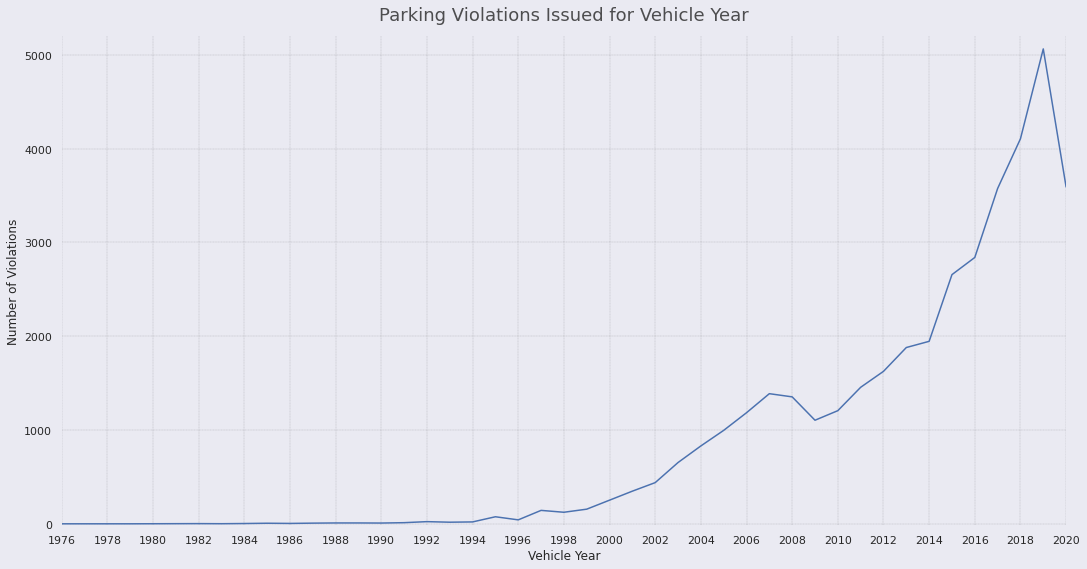

In [432]:
# set the figure size
fig = plt.figure(figsize=(18, 9))
# set the background color to mach the plot color
fig.patch.set_facecolor('#eaeaf2')
# disable the box around the plot
plt.box(False)


ax = sns.lineplot(x=violations_by_vehicle_year.index,
                  y=violations_by_vehicle_year.values) #sns.lineplot returns an axes object

# create two lists of labels
years = [x for x in range(1976, 2021, 2)]
ammount_violations = [0, 1000, 2000, 3000, 4000, 5000]

# set the xticks and yticks based on the lists created
ax.set_xticks(years)
ax.set_yticks(ammount_violations)

# set the x and y labels and limits
ax.set(xlabel='Vehicle Year', ylabel='Number of Violations', xlim = (1976, 2020), ylim = (-15, 5200))

# add a title
plt.title('Parking Violations Issued for Vehicle Year',
          size=18, alpha=0.8, y=1.02)

# disable the default seaborn grid
ax.grid(False)

# crate a custom grid
plt.vlines(years, *ax.get_ylim(), color='k', linestyles='--', lw=0.3, alpha=0.4)
plt.hlines(ammount_violations, *ax.get_xlim(), color='k', linestyles='--', lw=0.3, alpha=0.4)

# show the plot
plt.show();

###Top 5 violation codes

In [433]:
# create a series containing the top 5 violations codes
top_5_violations = df.groupby('Violation Code')['Summons Number'].count().nlargest(5)
top_5_violations.head()

Violation Code
36    14318
21     4318
38     2939
14     2143
20     2013
Name: Summons Number, dtype: int64

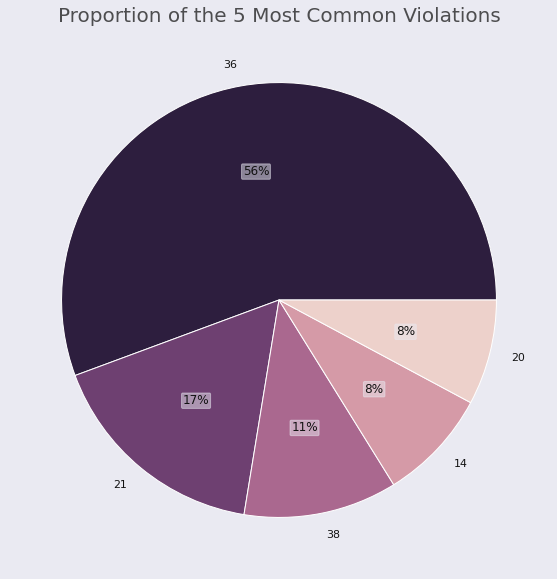

In [434]:
# set the figure size
fig = plt.figure(figsize=(10, 10))
# set the background color to mach the plot color
fig.patch.set_facecolor('#eaeaf2')

# create a plot and save the axes object it returns
ax = top_5_violations.plot.pie(colormap=color_map, autopct='%1.0f%%', textprops=text_props)

# set the labels (empty strings so they don't appear)
ax.set(xlabel='', ylabel='')

# set a title
plt.title('Proportion of the 5 Most Common Violations',
          size=20, alpha=0.8);

# show the plot
plt.show();

###List the top 5 violation codes for vehicles that are registered in states other than NY.

In [435]:
# create a series of the 5 top violations codes made by cars registed outside NY
top_5_no_NY = df[df['Registration State'] != 'NY'].groupby('Violation Code')['Summons Number'].count().nlargest(5)
top_5_no_NY

Violation Code
36    2772
5      365
7      350
12      62
21      30
Name: Summons Number, dtype: int64

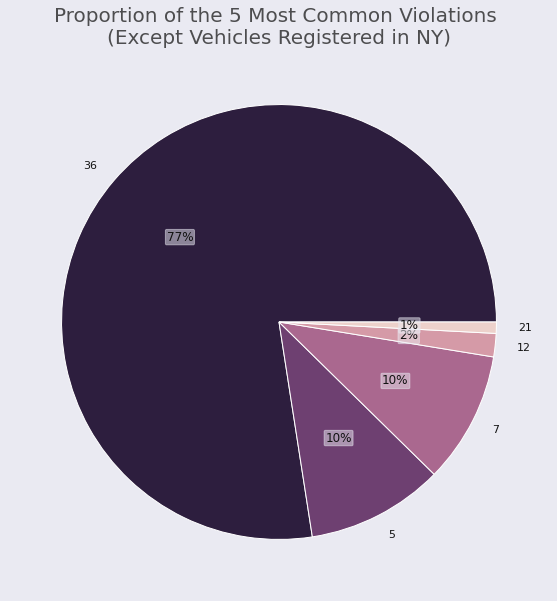

In [436]:
fig = plt.figure(figsize=(10, 10))
fig.patch.set_facecolor('#eaeaf2')

ax = top_5_no_NY.plot.pie(colormap=color_map, autopct='%1.0f%%', textprops=text_props)
ax.set(xlabel='', ylabel='')

plt.title('Proportion of the 5 Most Common Violations \n(Except Vehicles Registered in NY)',
          size=20, alpha=0.8);

plt.show();

###The streets where Hondas received the most parking violations.

In [437]:
streets_hondas = df[df['Vehicle Make']=='HONDA'].groupby('Street Name')['Summons Number'].count().nlargest(5)
streets_hondas

Street Name
Broadway                34
WB CONDUIT BLVD @ LI    31
WB QUEENS BLVD @ 72N    29
NB WEST ST @ LEROY S    25
EB W 14TH STREET @ 5    23
Name: Summons Number, dtype: int64

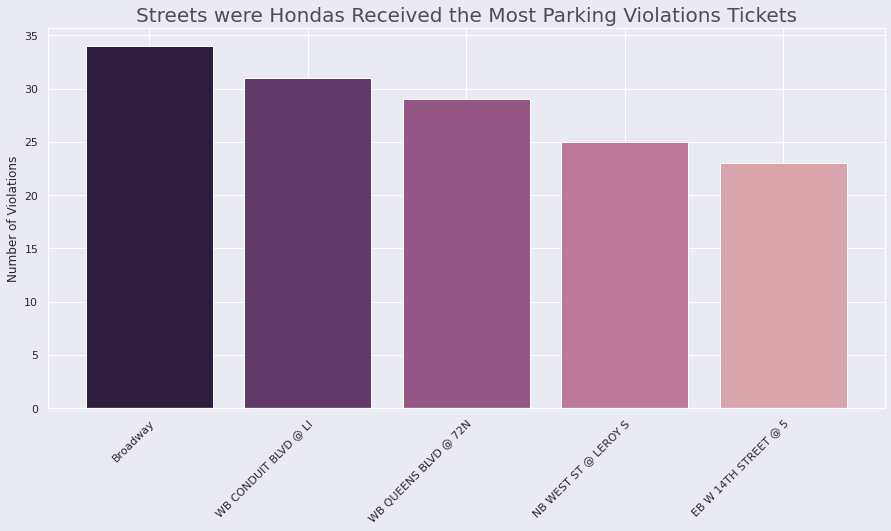

In [438]:
# set the figure size
fig = plt.figure(figsize=(15, 7))
fig.patch.set_facecolor('#eaeaf2')

# create a bar plot
plt.bar(streets_hondas.index, streets_hondas.values, color=sns.color_palette("ch:start=0,rot=.4_r"))

# rotate the xticks so they don't overlap
plt.xticks(rotation=45, rotation_mode="anchor", ha='right')

# add a title
plt.title('Streets were Hondas Received the Most Parking Violations Tickets',
          size=20, alpha=0.8);

# add a y label
plt.ylabel('Number of Violations')

# show the plot
plt.show();

### Ratio of plate types that are not passenger

For vehicles that are from NY only, create a plot displaying the 
ratio of plate types that are not passenger,
year by year.

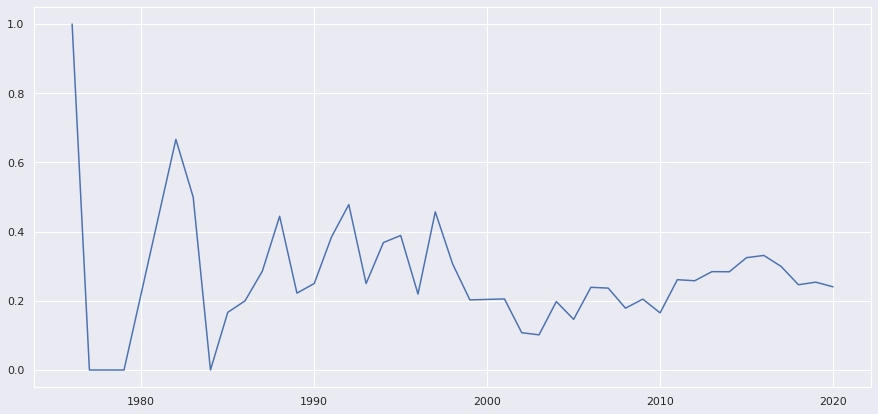

In [439]:
# Subset for only rows where the Registration State is NY.
df_ny = df[df['Registration State'] == 'NY']

# Calculate the ratio of non-passenger plates to all plates, grouped by year. 
df_ny_notpas = df_ny[df_ny['Plate Type'] != 'PAS'].groupby('Vehicle Year')['Summons Number'].count()
df_ny_all = df_ny.groupby('Vehicle Year')['Summons Number'].count()
ratio = df_ny_notpas / df_ny_all

# Replace nulls with 0.
ratio.fillna(0, inplace = True)

# Create and show plot.
fig = plt.figure(figsize=(15, 7))
fig.patch.set_facecolor('#eaeaf2')

plt.plot(ratio)
plt.show()

###Relation between vehicle color and plate type

Determine whether the color of vehicles with passenger plates receiving the most violations is the same as the color of vehicles with commercial plates receiving the most violations.

In [440]:
# First, let's plot a pie chart of the vehicle colors with the whole dataset
top_colors = df.groupby('Vehicle Color')['Summons Number'].count().nlargest(5)
top_colors

Vehicle Color
GY    8689
WH    8122
BK    7778
BL    2859
RD    1730
Name: Summons Number, dtype: int64

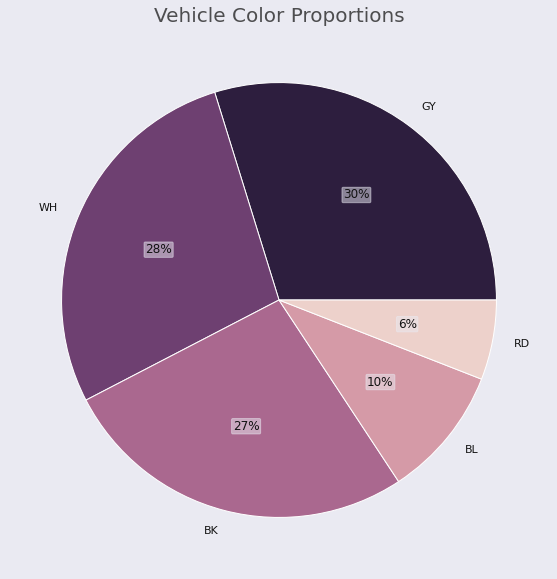

In [441]:
fig = plt.figure(figsize=(10, 10))
fig.patch.set_facecolor('#eaeaf2')

ax = top_colors.plot.pie(colormap=color_map, autopct='%1.0f%%', textprops=text_props)
ax.set(xlabel='', ylabel='')

plt.title('Vehicle Color Proportions',
          size=20, alpha=0.8);

plt.show();

In [442]:
top_colors_pas = df[df['Plate Type'] == 'PAS'].groupby('Vehicle Color')['Summons Number'].count().nlargest(5)
top_colors_pas

Vehicle Color
GY    7796
BK    6413
WH    4696
BL    2489
RD    1464
Name: Summons Number, dtype: int64

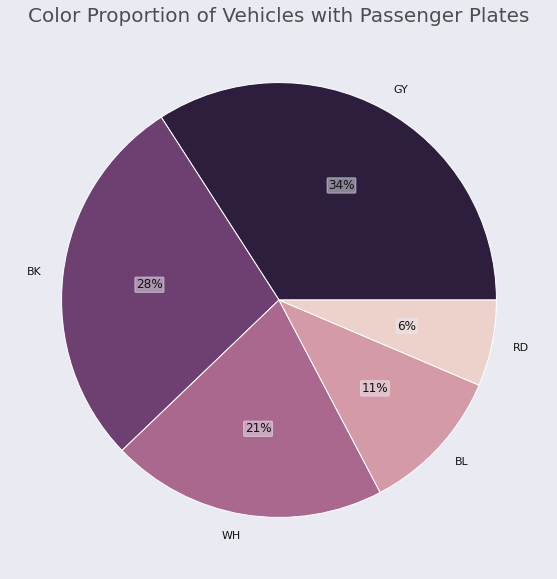

In [443]:
fig = plt.figure(figsize=(10, 10))
fig.patch.set_facecolor('#eaeaf2')

ax = top_colors_pas.plot.pie(colormap=color_map, autopct='%1.0f%%', textprops=text_props)
ax.set(xlabel='', ylabel='')

plt.title('Color Proportion of Vehicles with Passenger Plates',
          size=20, alpha=0.8);

plt.show();

In [444]:
top_colors_com = df[df['Plate Type'] == 'COM'].groupby('Vehicle Color')['Summons Number'].count().nlargest(5)
top_colors_com

Vehicle Color
WH       2882
WHITE     976
BROWN     953
GY        230
BL        186
Name: Summons Number, dtype: int64

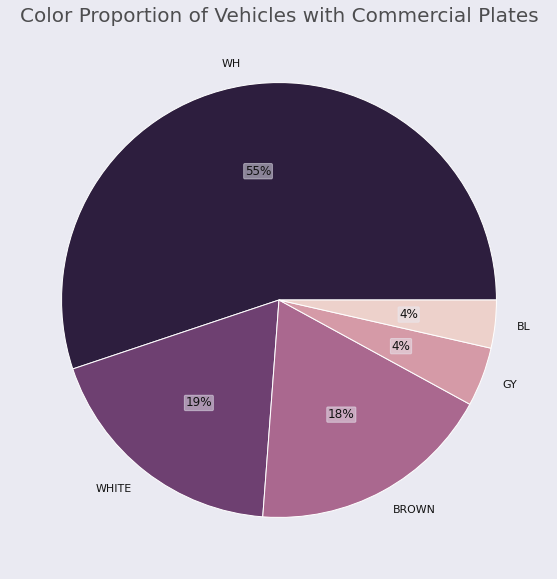

In [445]:
fig = plt.figure(figsize=(10, 10))
fig.patch.set_facecolor('#eaeaf2')

ax = top_colors_com.plot.pie(colormap=color_map, autopct='%1.0f%%', textprops=text_props)
ax.set(xlabel='', ylabel='')

plt.title('Color Proportion of Vehicles with Commercial Plates',
          size=20, alpha=0.8);

plt.show();

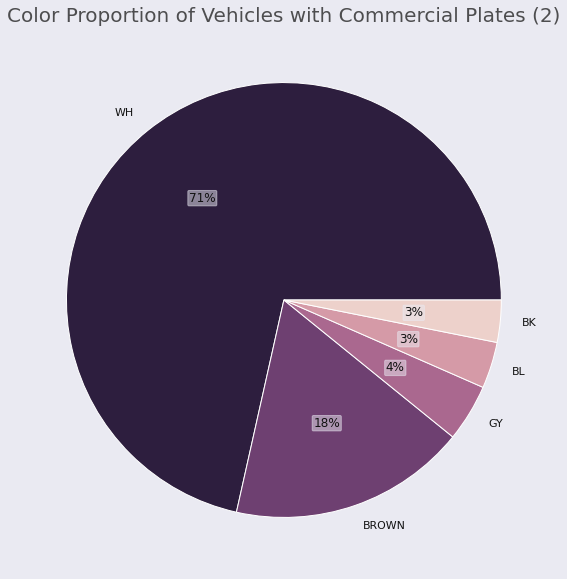

In [446]:
# As WH and WHITE correspond to the same thing, I'll merge them:

df.loc[df['Vehicle Color']=='WHITE', 'Vehicle Color'] = 'WH'

# Doing the plot again
top_colors_com = df[df['Plate Type'] == 'COM'].groupby('Vehicle Color')['Summons Number'].count().nlargest(5)

fig = plt.figure(figsize=(10, 10))
fig.patch.set_facecolor('#eaeaf2')

ax = top_colors_com.plot.pie(colormap=color_map, autopct='%1.0f%%', textprops=text_props)
ax.set(xlabel='', ylabel='')

plt.title('Color Proportion of Vehicles with Commercial Plates (2)',
          size=20, alpha=0.8);

plt.show();

In [447]:
# The final numbers
top_colors_com

Vehicle Color
WH       3858
BROWN     953
GY        230
BL        186
BK        169
Name: Summons Number, dtype: int64

###Number of parking violations per registration state
Display the number of registration states represented in the data and the average number of parking violations per registration state.

In [448]:
# Unique states
# unique states (except NY)
unq_states_noNY = df[df['Registration State'] != 'NY'].groupby('Registration State')['Summons Number'].count()
# all states
unq_states = df.groupby('Registration State')['Summons Number'].count()

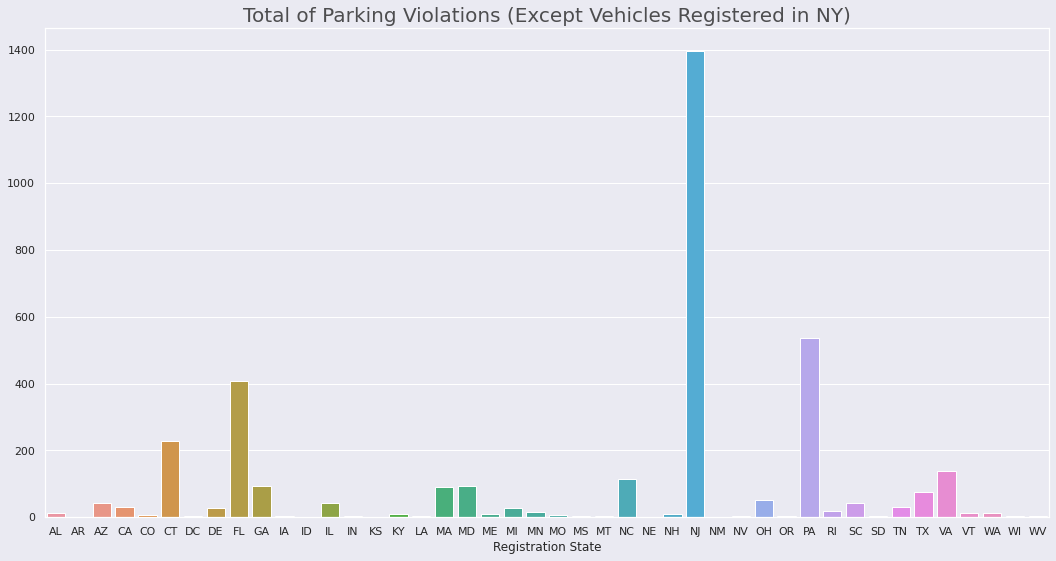

In [449]:
fig = plt.figure(figsize=(18, 9))
fig.patch.set_facecolor('#eaeaf2')

sns.barplot(x=unq_states_noNY.index, y=unq_states_noNY.values);
plt.title('Total of Parking Violations (Except Vehicles Registered in NY)',
          size=20, alpha=0.8);

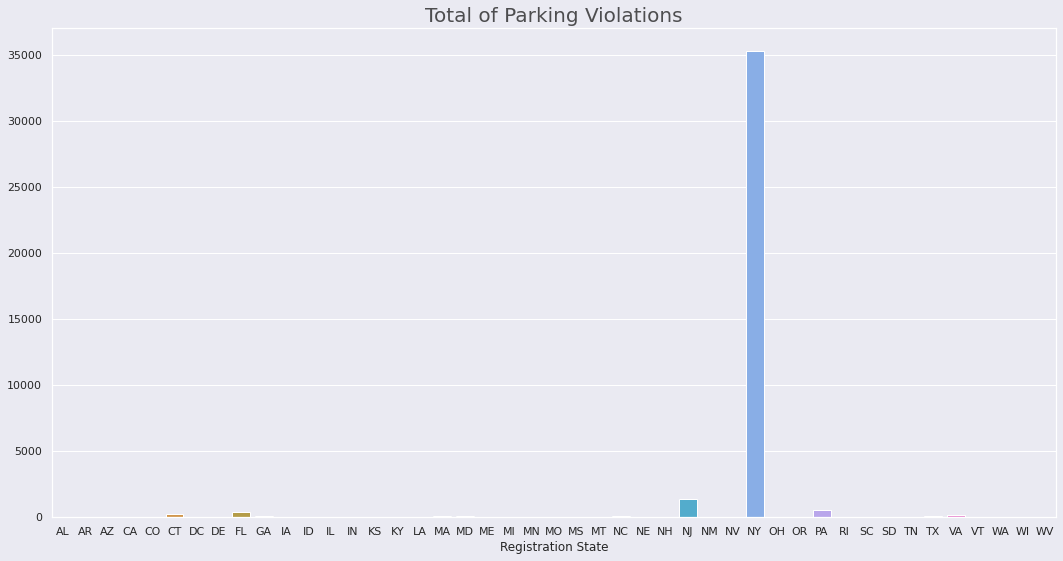

In [450]:
fig = plt.figure(figsize=(18, 9))
fig.patch.set_facecolor('#eaeaf2')

sns.barplot(x=unq_states.index, y=unq_states.values);
plt.title('Total of Parking Violations',
          size=20, alpha=0.8);

In [451]:
print('Number of Registration States: ' + str(df['Registration State'].nunique()))

print('Average Number of Parking Violations per Registration State: ' +  
      str(df.groupby('Registration State')['Summons Number'].count().mean()))

Number of Registration States: 45
Average Number of Parking Violations per Registration State: 865.1555555555556


###The most parking violations for each violation code.

In [452]:
df.groupby('Violation Code')['Plate Type'].apply(lambda x: x.value_counts().head(1)).reset_index(name='Count').rename(columns={'level_1': 'Plate Type'})

,Violation Code,Plate Type,Count
0,4,COM,4
1,5,PAS,1080
2,6,APP,3
3,7,PAS,1398
4,8,OMT,1
...,...,...,...
69,89,COM,1
70,91,PAS,2
71,95,PAS,1
72,98,PAS,91


###The percentage of parking violations in each county and display in descending order.

In [453]:
df_county = df.groupby('Violation County')['Summons Number'].count().reset_index(name='Amount')

In [454]:
df_county

,Violation County,Amount
0,BK,5874
1,BX,5199
2,K,5095
3,MN,2688
4,NY,8076
5,Q,5049
6,QN,5341
7,R,263
8,ST,1300


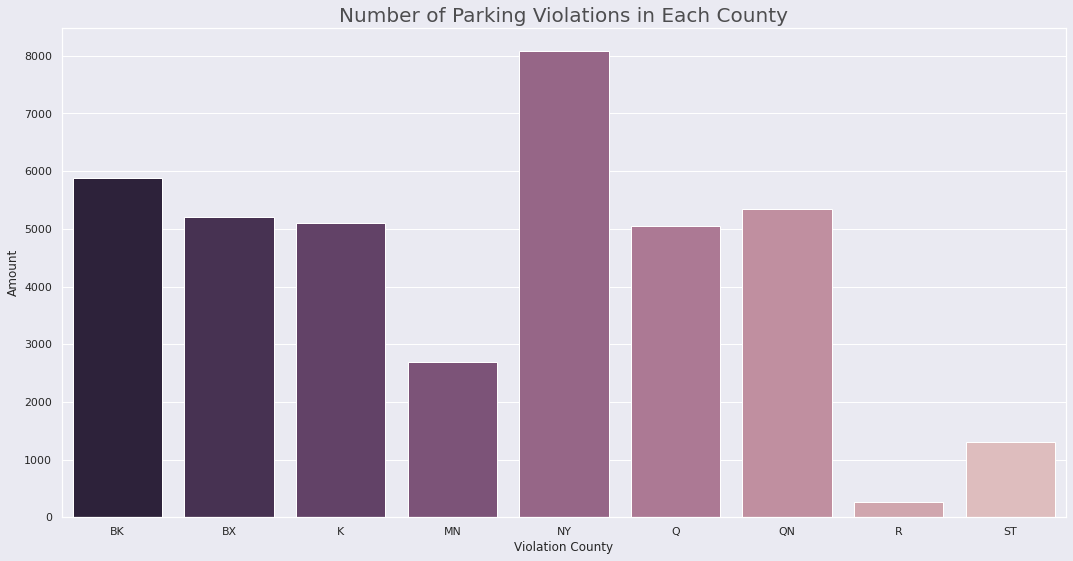

In [455]:
fig = plt.figure(figsize=(18, 9))
fig.patch.set_facecolor('#eaeaf2')

sns.barplot(x=df_county['Violation County'], y=df_county['Amount'], palette=sns.color_palette("ch:start=0,rot=.4_r", n_colors=10));
plt.title('Number of Parking Violations in Each County',
          size=20, alpha=0.8);

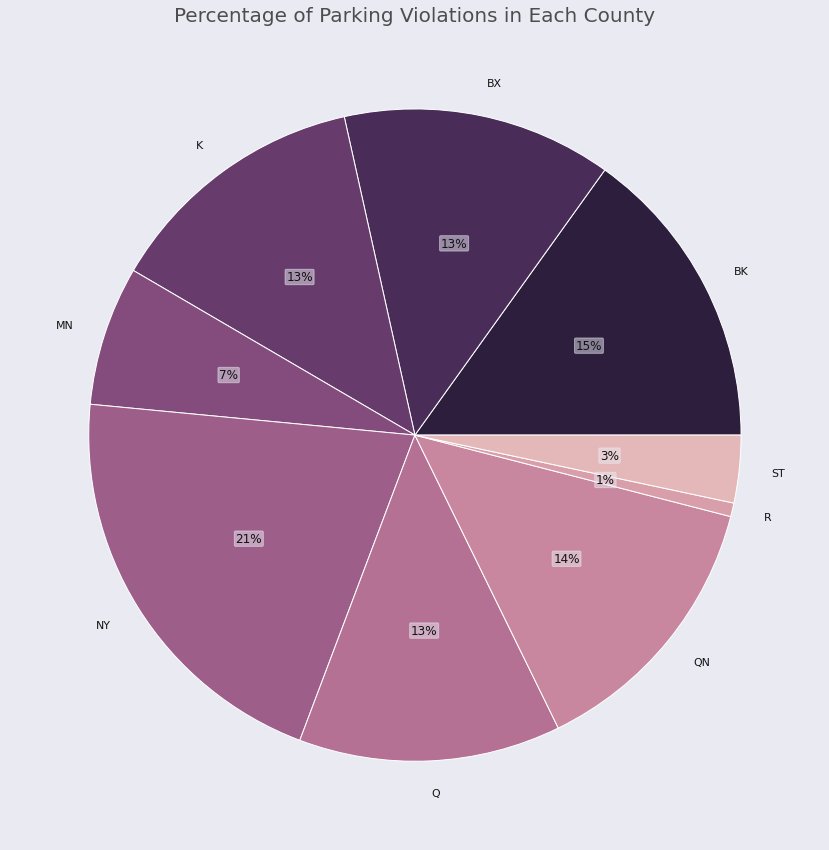

In [456]:
fig = plt.figure(figsize=(15, 15))
fig.patch.set_facecolor('#eaeaf2')

plt.pie(x=df_county['Amount'], labels=df_county['Violation County'], colors=sns.color_palette("ch:start=0,rot=.4_r", n_colors=10), textprops=text_props, autopct='%1.0f%%')

plt.title('Percentage of Parking Violations in Each County',
          size=20, alpha=0.8);

plt.show();